<a href="https://colab.research.google.com/github/lilyzhizhou/datathon-3/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [19]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
!pip install category_encoders
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score

Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Datathon #3/datapd.csv')

In [5]:
print(data.shape)
data.head()

(6414, 13)


,Unnamed: 0,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex,Patient_ID
0,2,1,63,30.9,NaN,0,1,0,1,0,1,1,1001000000000054
1,2386,1,66,23.6,3.54,1,1,1,0,0,1,1,1001000000004538
2,7781,0,68,34.3,5.55,1,1,1,0,0,1,0,1001000000007331
3,7644,1,73,28.5,3.78,1,1,0,1,1,1,0,1001000000007333
4,2290,0,53,33.4,5.38,0,1,1,0,1,1,0,1001000000009032


Preprocessing

In [6]:
#remove missing values
print(data.isna().sum())

Unnamed: 0             0
predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
Patient_ID             0
dtype: int64




*  only cholesterol has missing data (2.35%)



Text(0.5, 1.0, 'Histogram of Total Cholesterol')

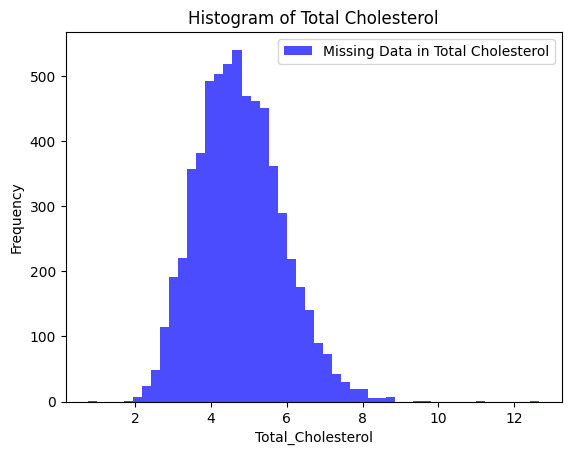

In [7]:
#histogram of missing values in cholesterol column
plt.hist(data['Total_Cholesterol'].dropna(), bins=50, alpha=0.7, color='blue', label='Missing Data in Total Cholesterol')
plt.xlabel('Total_Cholesterol')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Total Cholesterol')



*   looks like its safe to impute the missing values with median based on the histogram



In [8]:
#impute missing data in the cholesterol column with median
data['Total_Cholesterol']=data['Total_Cholesterol'].fillna(data['Total_Cholesterol'].median())

data.info()

# Print the cleaned DataFrame
print(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6414 entries, 0 to 6413
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6414 non-null   int64  
 1   predm              6414 non-null   int64  
 2   Age_at_Exam        6414 non-null   int64  
 3   BMI                6414 non-null   float64
 4   Total_Cholesterol  6414 non-null   float64
 5   Depression         6414 non-null   int64  
 6   HTN                6414 non-null   int64  
 7   OA                 6414 non-null   int64  
 8   COPD               6414 non-null   int64  
 9   corstrd_bin        6414 non-null   int64  
 10  htnmed_bin         6414 non-null   int64  
 11  Sex                6414 non-null   int64  
 12  Patient_ID         6414 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 651.5 KB
      Unnamed: 0  predm  Age_at_Exam   BMI  Total_Cholesterol  Depression  \
0              2      1           63  30.9 

In [9]:
#check again for missing values (NaN should be 0)
print(data.isna().sum())
median_chol = np.median(data['Total_Cholesterol'])
median_chol

Unnamed: 0           0
predm                0
Age_at_Exam          0
BMI                  0
Total_Cholesterol    0
Depression           0
HTN                  0
OA                   0
COPD                 0
corstrd_bin          0
htnmed_bin           0
Sex                  0
Patient_ID           0
dtype: int64


4.69

In [10]:
#check if the median of the newly imputed values are the same in each category of predm as before imputation (look at table file in drive for comparison)
chol_predm0 = data[data['predm'] == 0]
chol_predm1 = data[data['predm'] == 1]

# Calculate the median of taotal cholesterol for each category of predm
median_for_predm_0 = chol_predm0['Total_Cholesterol'].median()
median_for_predm_1 = chol_predm1['Total_Cholesterol'].median()

print("Median for predm 1:", median_for_predm_0)
print("Median for predm 1:", median_for_predm_1)

Median for predm 1: 4.78
Median for predm 1: 4.48


Data Splitting

In [11]:
# Splitting the data into 75% training and 25% testing
train = data.sample(frac=0.75, random_state=10)
test = data.drop(train.index)

Model Building

In [12]:
# Initializing a Random Forest classifier
random_forest = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', oob_score=True)

 #Classifier Pipeline
model = Pipeline([
    ('classifier', RandomForestClassifier())
])
model

Pipeline(steps=[('classifier', RandomForestClassifier())])

Model Training and Evaluation

In [13]:
# Using the pipeline model to train on the training data.
# Dropping the target column ('predm') from the input features.
model = model.fit(train.drop('predm', axis=1), train['predm'])

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_train_pred = model.predict(train.drop('predm', axis=1))
Y_train_pred = accuracy_score(train['predm'], Y_train_pred)
print("Train Set Accuracy:", Y_train_pred)

# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_test_pred = model.predict(test.drop('predm', axis=1))
Y_test_pred = accuracy_score(test['predm'], Y_test_pred)
print("Train Set Accuracy:", Y_test_pred)

Train Set Accuracy: 1.0
Train Set Accuracy: 0.7306733167082294


Hyperparameter Tuning with Grid Search

In [37]:
# Setting hyperparameters for Random Forest for the Grid Search.
param_dist = {
    "classifier__n_estimators" : [200, 300, 400],
    "classifier__max_depth" : [5,7,10],
    "classifier__min_samples_leaf" : [15, 20 ,25],
    "classifier__max_features" : [6,8,10],
    "classifier__criterion" : ['gini'],
    "classifier__min_samples_split" : [5, 10, 15],
    "classifier__min_samples_leaf" : [1],
    "classifier__max_leaf_nodes" : [100],
    "classifier__min_impurity_decrease" : [0.01],
    "classifier__min_weight_fraction_leaf" : [0.1],
    "classifier__bootstrap" : [True],
    "classifier__oob_score" : [True],
    "classifier__n_jobs" : [None],
    "classifier__warm_start" : [False]
}

# Initializing stratified K-fold cross-validation. This ensures each fold has the same proportion of target labels as the whole dataset.
kf = KFold(n_splits=10)

# Setting up GridSearchCV to search through the parameter space.
# It will evaluate the model for each combination of hyperparameters provided using stratified K-fold cross-validation.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data.
random_search.fit(train.drop('predm', axis=1), train['predm'])

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__bootstrap,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__max_leaf_nodes,param_classifier__min_impurity_decrease,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__min_weight_fraction_leaf,param_classifier__n_estimators,param_classifier__n_jobs,param_classifier__oob_score,param_classifier__warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
55,1.343952,0.246705,0.028512,0.005986,True,gini,10,6,100,0.01,1,5,0.1,300,None,True,False,"{'classifier__bootstrap': True, 'classifier__c...",0.713098,0.686071,0.744283,0.725572,0.717256,0.725572,0.704782,0.738046,0.738046,0.717256,0.720998,0.016549,1


In [40]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'classifier__bootstrap': True,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 6,
 'classifier__max_leaf_nodes': 100,
 'classifier__min_impurity_decrease': 0.01,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__min_weight_fraction_leaf': 0.1,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': None,
 'classifier__oob_score': True,
 'classifier__warm_start': False}

Using Optimal Hyperparameters to Train and Evaluate the Model

In [46]:
# Updating the model's hyperparameters with the best parameters identified from the Grid Search.
model = model.set_params(**random_search.best_params_)

# Retraining the model with the updated hyperparameters on the training data.
model = model.fit(train.drop('predm', axis=1), train['predm'])

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_train_pred = model.predict(train.drop('predm', axis=1))
accuracy = accuracy_score(train['predm'], Y_train_pred)
print("Train Set Accuracy:", accuracy)

# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_test_pred = model.predict(test.drop('predm', axis=1))
accuracy = accuracy_score(test['predm'], Y_test_pred)
print("Test Set Accuracy:", accuracy)

Train Set Accuracy: 0.7203742203742204
Test Set Accuracy: 0.7350374064837906


Performance Metrics

In [48]:
# F1
F1 = f1_score(test['predm'], Y_test_pred)
print("Test Set F1:", F1)

Test Set F1: 0.6222222222222223


In [49]:
# Precision Score
Precision = precision_score(test['predm'], Y_test_pred)
print("Test Set Precision:", Precision)

Test Set Precision: 0.7760532150776053


In [50]:
# Recall Score
Recall = recall_score(test['predm'], Y_test_pred)
print("Test Set Recall:", Recall)

Test Set Recall: 0.5192878338278932


In [51]:
#AUC
roc_auc = roc_auc_score(test['predm'], Y_test_pred)
print("Test Set AUC:", roc_auc)

Test Set AUC: 0.7053428416451294


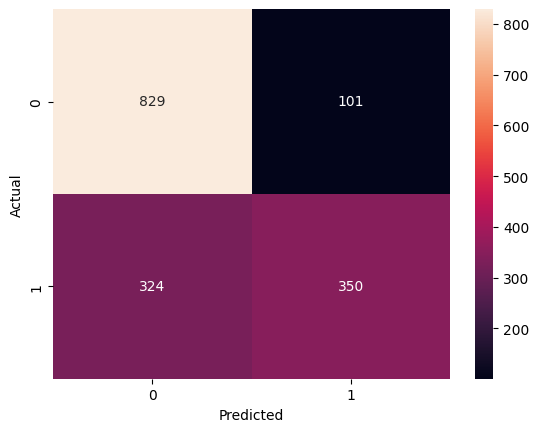

In [53]:
#confusion matrix
Y = test['predm']
conf_matrix = confusion_matrix(Y, Y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()